# Can RNNs add numbers together?

In [195]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import trange

RANDOM_SEED = 42
torch.manual_seed(RANDOM_SEED);

In [196]:
class AdderSet(Dataset):
    def __init__(self, n_observations, seq_len):
        self.x = torch.randn((n_observations, seq_len, 1))
        self.y = torch.sum(self.x, axis=1)
        self.n = n_observations
    
    def __getitem__(self, i):
        return self.x[i], self.y[i]
    
    def __len__(self):
        return self.n

In [197]:
n = 100_000
p = 3
trainset = AdderSet(n, p)
trainloader = DataLoader(trainset, batch_size=32)

testset = AdderSet(n, p)
testloader = DataLoader(trainset, batch_size=n)

next(iter(trainloader))[0].shape

torch.Size([32, 3, 1])

In [228]:
class Adder(nn.Module):
    def __init__(self, p):
        super().__init__()
        self.p = p
        self.hidden_size = 16
        self.lstm = nn.LSTM(1, hidden_size=self.hidden_size, batch_first=True)
        self.linear = nn.Sequential(
            nn.ReLU(),
            nn.Linear(self.hidden_size, 1)
        )
        
    def forward(self, x):
        hs, _ = self.lstm(x)
        h = hs[:, -1, :]  # Taking the last element as a representation of LSTM
        y = self.linear(h)
        return y

In [234]:
adder = Adder(p)

def fit(adder, verbose=True):
    # Training loop
    criterion = nn.MSELoss()
    lr = 0.01
    optimizer = optim.Adam(adder.parameters(), lr=lr)

    losses = []

    n_epochs = 3

    for epoch in trange(n_epochs):
        for x, y in trainloader:
            optimizer.zero_grad()
            y_pred = adder(x)
            loss = criterion(y, y_pred)
            loss.backward()
            optimizer.step()
            losses.append(loss.item())

    if verbose:
        plt.plot(losses)
        plt.xlabel("iteration")
        plt.ylabel("MSE loss");
        plt.show()

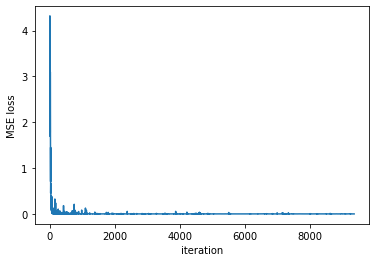

In [235]:
fit(adder)

In [236]:
adder.eval()
with torch.no_grad():
    for x, y in testloader:
        y_pred = adder(x)
        loss = criterion(y, y_pred)
print(loss.item())

tensor(8.5805e-05)


As we see, LSTM learned how to add with reasonable degreee of accuracy.

In [237]:
x = [0, 0, 0]
x = torch.tensor([0, 0, 0]).float().view(1, 3, 1)
adder(x).item()

0.006837010383605957

However, let's see what happens for number out of normal range.

In [238]:
x = torch.tensor([3, 3, 3]).float().view(1, 3, 1)
adder(x).item()

6.822782039642334

We already see some weird things going on.

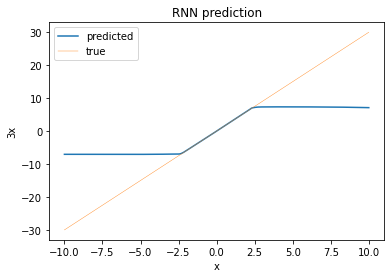

In [239]:
xs = np.linspace(-10, 10, 1000)
ys_true = 3*xs
ys_pred = []
for value in xs:
    x = torch.tensor([value for _ in range(3)]).float().view(1, 3, 1)
    with torch.no_grad():
        ys_pred.append(adder(x).item())

plt.plot(xs, ys, label="predicted")
plt.plot(xs, ys_true, linewidth=0.4, label="true")
plt.xlabel("x")
plt.ylabel("3x")
plt.title("RNN prediction")
plt.legend();

---
#### Taknig mean of hidden states instead of using just last state

In [242]:
class Adder(nn.Module):
    def __init__(self, p):
        super().__init__()
        self.p = p
        self.hidden_size = 16
        self.lstm = nn.LSTM(1, hidden_size=self.hidden_size, batch_first=True)
        self.linear = nn.Sequential(
            nn.ReLU(),
            nn.Linear(self.hidden_size, 1)
        )
        
    def forward(self, x):
        hs, _ = self.lstm(x)
        h = torch.mean(hs, axis=1)  # Taking a mean of hidden states as a representation
        y = self.linear(h)
        return y

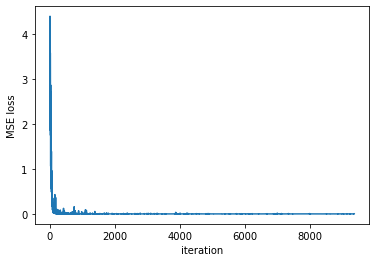

In [243]:
adder = Adder(3)
fit(adder)

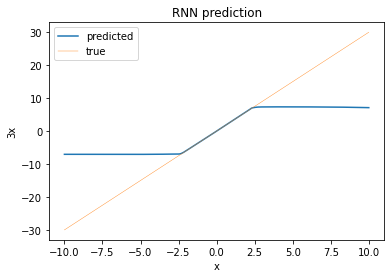

In [245]:
xs = np.linspace(-10, 10, 1000)
ys_true = 3*xs
ys_pred = []
for value in xs:
    x = torch.tensor([value for _ in range(3)]).float().view(1, 3, 1)
    with torch.no_grad():
        ys_pred.append(adder(x).item())

plt.plot(xs, ys, label="predicted")
plt.plot(xs, ys_true, linewidth=0.4, label="true")
plt.xlabel("x")
plt.ylabel("3x")
plt.title("RNN prediction")
plt.legend();

It didn't change anything.